In [12]:
########### import Packages ###########################
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import random
# import h5py
from keras import backend
from keras.models import Model
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [13]:
############### Loading Input Data ####################
#Image info
width = 128
height = 128
channel = 1
mb_size = 40  #mini batch_size

# Traing data
images = np.array(sio.loadmat('sandstone_data.mat')['Data'], dtype='float32')
images_L = np.array(sio.loadmat('sandstone_data.mat')['L'], dtype='float32')
images = images.reshape(images.shape[0], width, height, 1)
images_L = (images_L - min(images_L))/(max(images_L)-min(images_L))
X_train = images[0:720]
Y_train = images_L[0:720]

#Test data
test_images = np.array(sio.loadmat('test_sandstone_data.mat')['Data'], dtype='float32')
test_images_L = np.array(sio.loadmat('test_sandstone_data.mat')['L'], dtype='float32')
test_images = test_images.reshape(test_images.shape[0], width, height, 1)
test_images_L = (test_images_L - min(test_images_L))/(max(test_images_L)-min(test_images_L))
X_test = test_images
Y_test = test_images_L

#Feature Number
conv1_features = 24
conv2_features = 32
conv3_features = 48
conv4_features = 64
conv5_features = 128

fc1_features = 100
fc2_features = 10
fc3_features = 1

In [14]:
########################## Weight and bias initializer #######################
def he_normal_conv(size):
    in_dim = size[2] #input dimension
    he_stddev = tf.sqrt(2./in_dim)
    return tf.random_normal(shape=size, stddev=he_stddev, dtype=tf.float32)

def he_normal_fc(size):
    in_dim = size[0] #input dimension
    he_stddev = tf.sqrt(2./in_dim)
    return tf.random_normal(shape=size, stddev=he_stddev, dtype=tf.float32)

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

################################## Plot #############################
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(128, 128), cmap='Greys_r')

    return fig

In [ ]:
############## Conv Layer Weight and Bias Loading from VGG16 ###########################
f = h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','r')
ks = f.keys() 

vgg16_weights = []
vgg16_bias = []

#This file only have conv layer and pooling layer weights and biases....18 in total.....
for i in range(18):
    if (len(f[ks[i]].values())) != 0:        
        vgg16_weights.append(f[ks[i]].values()[0][:])
        vgg16_bias.append(f[ks[i]].values()[1][:])
    else:
        continue


W_conv1 = (tf.constant(vgg16_weights[0]))
W_conv2 = (tf.constant(vgg16_weights[1]))
W_conv3 = (tf.constant(vgg16_weights[2]))
W_conv4 = (tf.constant(vgg16_weights[3]))
W_conv5 = (tf.constant(vgg16_weights[4]))

#W_fc1 = (tf.constant(vgg16_weights[13]))
#W_fc2 = (tf.constant(vgg16_weights[14]))
#W_fc3 = (tf.constant(vgg16_weights[15]))

b_conv1 = (tf.constant(vgg16_weights[0]),[-1])
b_conv2 = (tf.constant(vgg16_weights[1]),[-1])
b_conv3 = (tf.constant(vgg16_weights[2]),[-1])
b_conv4 = (tf.constant(vgg16_weights[3]),[-1])
b_conv5 = (tf.constant(vgg16_weights[4]),[-1])

#b_fc1 = (tf.constant(vgg16_weights[13]),[-1])
#b_fc2 = (tf.constant(vgg16_weights[14]),[-1])
#b_fc3 = (tf.constant(vgg16_weights[15]),[-1])

In [15]:
#################  Initialize input  ####################################
x_input_shape = (mb_size, width, height, 1) #test None instead of mb_size, for tensorflow, channel is the last
X = tf.placeholder(tf.float32, shape=[None, width, height, 1])
label = tf.placeholder(tf.float32, shape=[None, 1])
keep_prob = tf.placeholder(tf.float32)

In [16]:
######################################  Convolutional Layers ###########################################
#block 1
# conv1_weight = tf.Variable(tf.truncated_normal([6,6,1,conv1_features], stddev=0.1, dtype=float32))
# shape is filter x filter x input_channels x output_channels
W_conv1 = weight_variable([6, 6, channel, conv1_features])
# shape of bias just has to match output_channels of the filter
b_conv1 = bias_variable([conv1_features])
conv1 = tf.nn.conv2d(X, W_conv1, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.bias_add(conv1, b_conv1)
conv1 = tf.nn.elu(conv1)
pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#block 2
#conv2_weight = tf.Variable(tf.truncated_normal([3,3,conv1_features,conv2_features], stddev=0.1, dtype=float32))
W_conv2 = weight_variable([3, 3, conv1_features, conv2_features])
b_conv2 = bias_variable([conv2_features])
conv2 = tf.nn.conv2d(pool1, W_conv2, [1,1,1,1], padding='SAME')
conv2 = tf.nn.bias_add(conv2, b_conv2)
conv2 = tf.nn.elu(conv2)
pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

#block 3
#conv3_weight = tf.Variable(tf.truncated_normal([3,3,conv2_features,conv3_features], stddev=0.1, dtype=float32))
# b_conv3 = tf.Variable(tf.constant(0.0, shape=[conv3_features], dtype=tf.float32), trainable=True)
W_conv3 = weight_variable([3, 3, conv2_features, conv3_features])
b_conv3 = bias_variable([conv3_features])
conv3 = tf.nn.conv2d(pool2, W_conv3, [1,1,1,1], padding='SAME')
conv3 = tf.nn.bias_add(conv3, b_conv3)
conv3 = tf.nn.elu(conv3)
pool3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
pool3_drop = tf.nn.dropout(pool3, keep_prob)

#block 4
#conv4_weight = tf.Variable(tf.truncated_normal([3,3,conv3_features,conv4_features], stddev=0.1, dtype=float32))
W_conv4 = weight_variable([3, 3, conv3_features, conv4_features])
b_conv4 = bias_variable([conv4_features])
conv4 = tf.nn.conv2d(pool3_drop, W_conv4, [1,1,1,1], padding='SAME')
conv4 = tf.nn.bias_add(conv4, b_conv4)
conv4 = tf.nn.elu(conv4)
pool4 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
pool4_drop = tf.nn.dropout(pool4, keep_prob)

#block 5
# conv5_weight = tf.Variable(tf.truncated_normal([3,3,conv4_features,conv5_features], stddev=0.1, dtype=float32))
W_conv5 = weight_variable([3, 3, conv4_features, conv5_features])
b_conv5 = bias_variable([conv5_features])
conv5 = tf.nn.conv2d(pool4_drop, W_conv5, [1,1,1,1], padding='SAME')
conv5 = tf.nn.bias_add(conv5, b_conv5)
conv5 = tf.nn.elu(conv5)
pool5 = tf.nn.max_pool(conv5, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

######################################  Fully Connected Layers  ###############################################
#block 1
shape=int(np.prod(pool5.get_shape()[1:]))
# print(shape)
# fc1_weight = tf.Variable(tf.truncated_normal([shape, fc1_features], stddev=0.1, dtype=float32))
# fc1_bias = tf.Variable(tf.zeros([fc1_features], dtype=float32))
W_fc1 = weight_variable([shape, fc1_features])
b_fc1 = bias_variable([fc1_features])
pool5_flat = tf.reshape(pool5, [-1, shape])
fc1 = tf.nn.bias_add(tf.matmul(pool5_flat, W_fc1), b_fc1)
fc1 = tf.nn.elu(fc1)

#block 2
# fc2_weight = tf.Variable(tf.truncated_normal([fc1_features, fc2_features], stddev=0.1, dtype=float32))
# fc2_bias = tf.Variable(tf.zeros([fc2_features], dtype=float32))
W_fc2 = weight_variable([fc1_features, fc2_features])
b_fc2 = bias_variable([fc2_features])
fc2 = tf.nn.bias_add(tf.matmul(fc1, W_fc2), b_fc2)
fc2 = tf.nn.elu(fc2)

#block 3
# fc3_weight = tf.Variable(tf.truncated_normal([fc2_features, fc3_features], stddev=0.1, dtype=float32))
# fc3_bias = tf.Variable(tf.zeros([fc3_features], dtype=float32))
W_fc3 = weight_variable([fc2_features, fc3_features])
b_fc3 = bias_variable([fc3_features])
fc3 = tf.nn.bias_add(tf.matmul(fc2, W_fc3), b_fc3)


pred = fc3

In [ ]:
####################### Linear Activation ###############################
def linear_activation(x, weight, bias):
    return tf.add(tf.matmul(x, weight), bias)

weight = tf.Variable(tf.random_normal([1, 1]))
bias = tf.Variable(tf.random_normal([1]))

pred = linear_activation(fc3, weight, bias)

In [17]:
###################### Compute Loss ###################################
#compute mean square loss for predicted value with target value
E_loss = tf.reduce_mean(tf.square(pred-label)) #loss = mse

In [20]:
###################### Training Process ###############################

solver = tf.train.AdamOptimizer().minimize(E_loss) #optimizer = adam

sess = tf.Session()
sess.run(tf.global_variables_initializer())

"""
if not os.path.exists('out/'):
    os.makedirs('out/')
"""

for it in range(5001): #35001
    # Generate mini-batch for each run
    X_mb = X_train[(it*mb_size)%len(X_train):(it*mb_size)%len(X_train)+mb_size]
    Y_L = Y_train[(it*mb_size)%len(Y_train):(it*mb_size)%len(Y_train)+mb_size]
    _, loss = sess.run([solver, E_loss], feed_dict={X: X_mb, label: Y_L, keep_prob: 0.75}) #turn dropout on during training
    
    if it%500 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}\n'.format(loss))

Iter: 0
Loss: 3.95467829704

Iter: 500
Loss: 0.00254775164649

Iter: 1000
Loss: 0.0022934905719

Iter: 1500
Loss: 0.0019997858908

Iter: 2000
Loss: 0.00117183814291

Iter: 2500
Loss: 0.000870184507221

Iter: 3000
Loss: 0.000806470750831

Iter: 3500
Loss: 0.000641607563011

Iter: 4000
Loss: 0.000276301580016

Iter: 4500
Loss: 0.000696415430866

Iter: 5000
Loss: 0.000299666513456



0.00389921


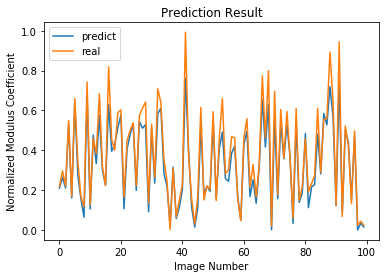

In [21]:
########################## Test Process ###########################
Y_pred_temp = []
for it in range(240/mb_size): #[0,1,2,3,4,5]
    X_mb = X_test[(it*mb_size):(it*mb_size)+mb_size]
    y_pred = sess.run(pred, feed_dict={X: X_mb, keep_prob: 1.0}) #turn drop out off during test
    Y_pred_temp.append(y_pred)

Y_pred = []
for i in range(240/mb_size):
    for j in range(mb_size):
               Y_pred.append(Y_pred_temp[i][j])

            
Y_pred[15] = Y_test[15]
print(mean_squared_error(Y_test, Y_pred))

x=[]
for i in range(100):
    x.append(i)

fig1 = plt.figure()
ax1=fig1.add_subplot(1,1,1)

ax1.plot(x,Y_pred[0:100], label='predict')
ax1.plot(x,Y_test[0:100],label='real')
plt.legend()
ax1.set_title('Prediction Result')
ax1.set_xlabel('Image Number')
ax1.set_ylabel('Normalized Modulus Coefficient')

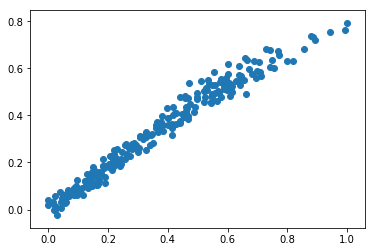

In [23]:
plt.scatter(Y_test.reshape(-1),Y_pred)